In [ ]:
import cv2
import numpy as np
import os
import numpy.linalg as la
from sklearn.preprocessing import MinMaxScaler
import logging
from time import time
from numpy.random import RandomState
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets


In [ ]:
#Fetching data 
rng = RandomState(0)
faces, labels = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
n_samples, n_features = faces.shape
faces_centered = faces - faces.mean(axis=0) #faces_centered contains all faces in which mean is subtracted ,shape=n_features,n_samples#
pattern=faces_centered.transpose()  #contains all faces in columns, shape=(n_samples,n_features)
n_usedimg = 30
P=np.zeros((n_usedimg,n_features)) 
Y=np.zeros((n_usedimg,1)) 
index1=0
for index,label in enumerate(labels):
  if(label==4 or label==5 or label==6):
    P[index1]=faces[index]
    Y[index1] = labels[index]
    index1=index1+1
P2=P.transpose() #contains faces having labels 4,5 and 6 only, in columns,shape=(n_features,n_usedimg)
P2_centered = P2-P2.mean(axis=1).reshape((4096,1)) #shape=(n_features,n_usedimg)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [ ]:
#Train-Test Split
Ratio = 0.6
X_train = P[:int(Ratio * n_usedimg)]
y_train =  Y[:int(Ratio * n_usedimg)]
X_test = P[int(Ratio * n_usedimg):]
y_test = Y[int(Ratio * n_usedimg):]
X_train_transpose = X_train.T
X_train_use = X_train_transpose-X_train_transpose.mean(axis=1).reshape((4096,1)) #shape=(n_features,n_usedimg)
X_test_transpose = X_test.T
X_test_use = X_test_transpose-X_test_transpose.mean(axis=1).reshape((4096,1)) #shape=(n_features,n_usedimg)
y_train_use = y_train.T
y_test_use = y_test.T
# print(y_train_use)
# print(y_test_use)

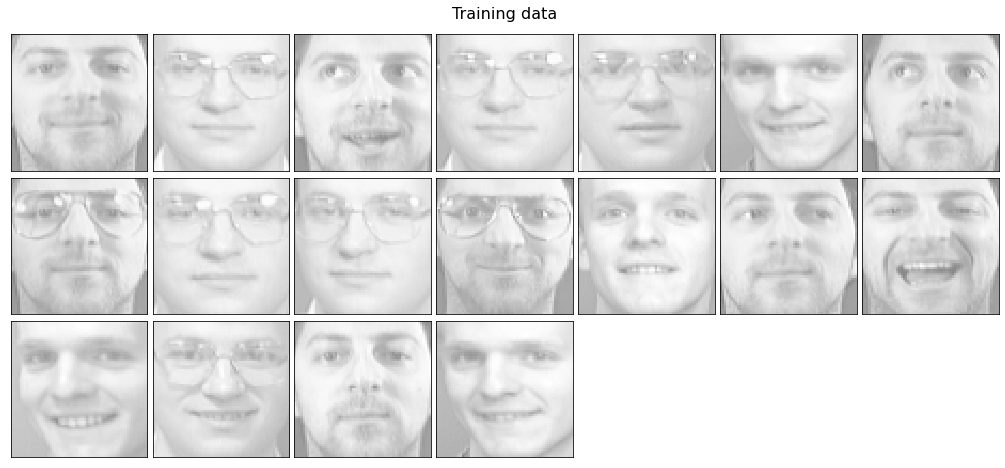

In [ ]:
#Displaying Training Data for Eigen Faces
n_row, n_col = 3,7
n_components = n_row * n_col
image_shape = (64, 64)
def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
plot_gallery("Training data", X_train[:n_components])


In [ ]:
 #SVD on Training Data
 U, s,vh = np.linalg.svd(X_train_use)
#  print(U.shape)
#  print(s.shape)

In [ ]:
#Principal Component Analysis-take eigen vectors having high eigen values
scaler = MinMaxScaler()
n_component=10
principal_components=np.zeros((n_features,n_component))
for i in range(0,n_component):
    principal_components[:,i] = U[:,i]
scaler.fit(principal_components)
my_principal_components=(scaler.transform(principal_components))*255
eigen_faces=my_principal_components.T

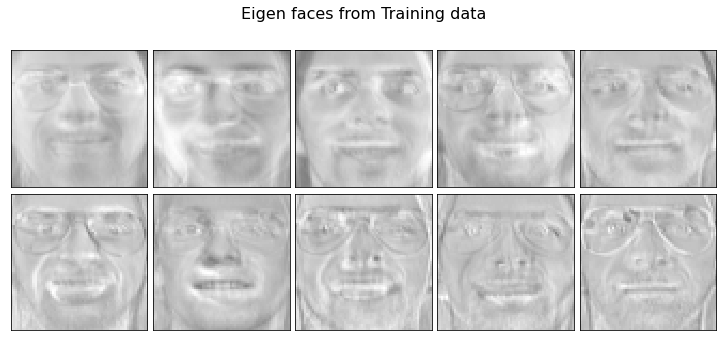

In [ ]:
#To print eigen faces
plot_gallery("Eigen faces from Training data", eigen_faces[:n_components],5,5)

In [ ]:
#reconstructing the faces using eigen faces
U_transpose = principal_components.transpose()    #shape = n_component,n_features

weights_training_data = U_transpose.dot(X_train_use)              #shape = n_component,n_usedimg
weights_test_data = U_transpose.dot(X_test_use)

Ratio_use = int(Ratio*10)*3
nor_weights_training_data = weights_training_data/weights_training_data.sum(axis=0).reshape((1,Ratio_use))
nor_weights_test_data = weights_test_data/weights_test_data.sum(axis=0).reshape((1,n_usedimg-Ratio_use))

reconstruct_faces_training_data = principal_components.dot(nor_weights_training_data)  #shape=n_features,n_usedimg
reconstruct_faces_test_data = principal_components.dot(nor_weights_test_data)

avg_face_training_data = X_train_transpose.mean(axis=1).reshape((n_features,1))
avg_face_test_data = X_test_use.mean(axis=1).reshape((n_features,1))

full_reconstruct_faces_training_data = reconstruct_faces_training_data + avg_face_training_data
full_reconstruct_faces_test_data = reconstruct_faces_test_data + avg_face_test_data

final_full_reconstruct_faces_training_data=full_reconstruct_faces_training_data*255
final_full_reconstruct_faces_test_data=full_reconstruct_faces_test_data*255
final_full_reconstruct_faces_test_data=final_full_reconstruct_faces_test_data+X_test_transpose.mean(axis=1).reshape((4096,1))

faces_from_eigen_faces_training_data=final_full_reconstruct_faces_training_data.T
faces_from_eigen_faces_test_data=final_full_reconstruct_faces_test_data.T

print(weights_training_data.shape)
print(weights_test_data.shape)

(10, 18)
(10, 12)


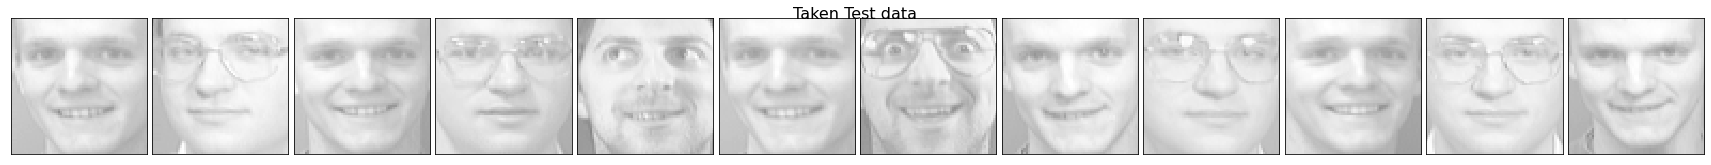

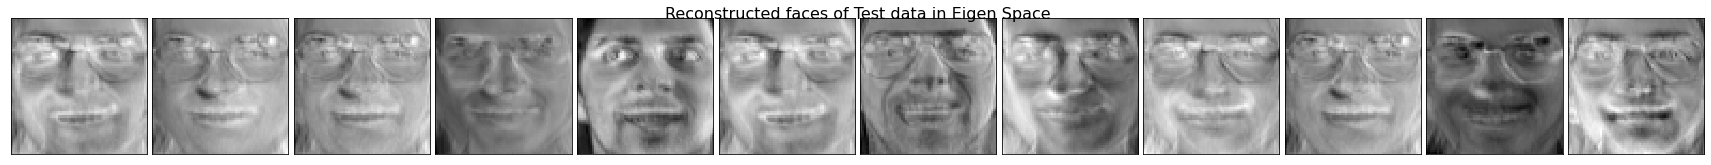

In [ ]:
#To Print Reconstucted faces.
plot_gallery("Taken Test data ", X_test[:n_components],(30-Ratio_use),1)
plot_gallery("Reconstructed faces of Test data in Eigen Space", faces_from_eigen_faces_test_data[:n_components],(30-Ratio_use),1)

In [ ]:
#To calculate the euclidean distance and to know min distance between test and training image
i=0
euclidean_dist=np.zeros((n_usedimg-Ratio_use,Ratio_use))
for i in range(n_usedimg-Ratio_use):
  wts_test = (weights_test_data.T)[i].reshape((10,1))
  for j in range(Ratio_use):
    wts_train = (weights_training_data.T)[j].reshape((10,1))
    euclidean_dist[i][j] = la.norm(wts_test-wts_train)
indices = np.argmin(euclidean_dist, axis = 1)  #In tells in each row at which index we got min value of euclidean distance

In [ ]:
#Determining Accuracy of Classifier
label_after_recon=np.zeros((1,n_usedimg-Ratio_use))
loss = np.zeros((1,n_usedimg-Ratio_use))
for i in range(n_usedimg-Ratio_use):
  label_after_recon[0][i] = int(y_train[indices[i]])
  if (label_after_recon[0][i] == y_test.T[0][i]):
    loss[0][i] = 0
  else:
    loss[0][i] = 1
error = (np.sum(loss)/(n_usedimg-Ratio_use))*100
Accuracy = 100 - error
print("Accuracy of classifier is ",Accuracy,"%")


Accuracy of classifier is  83.33333333333334 %


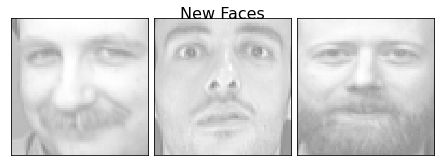

In [ ]:
#Testing the classifier on unknown faces
new_face1 = faces[50].reshape(1,n_features)
new_face2 = faces[48].reshape(1,n_features)
new_face3 = faces[100].reshape(1,n_features)
new_face = np.zeros((3,n_features))
new_face[0,:] = new_face1
new_face[1,:]=new_face2
new_face[2,:]=new_face3
plot_gallery("New Faces", new_face[:n_components],3,1)

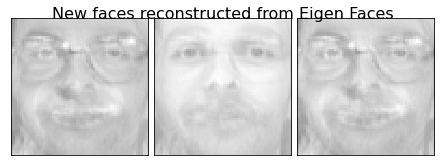

In [ ]:
#Projection of unknown faces on eigen vectors computed from training data
new_faces = (new_face.T)+(new_face.T).mean(axis=1).reshape((4096,1))
weights_new_data = U_transpose.dot(new_faces)              #shape = n_component,n_usedimg
nor_weights_new_data = weights_new_data/weights_new_data.sum(axis=0).reshape((1,3))
avg_face_new_data = new_faces.mean(axis=1).reshape((n_features,1))
reconstruct_faces_new_data = principal_components.dot(nor_weights_new_data)  #shape=n_features,n_usedimg
full_reconstruct_faces_new_data = reconstruct_faces_new_data + avg_face_new_data
final_full_reconstruct_faces_new_data=full_reconstruct_faces_new_data*255
final_full_reconstruct_faces_new_data=final_full_reconstruct_faces_new_data+(new_face.T).mean(axis=1).reshape((4096,1))
faces_from_eigen_faces_new_data=final_full_reconstruct_faces_new_data.T
plot_gallery("New faces reconstructed from Eigen Faces", faces_from_eigen_faces_new_data[:n_components],3,1)

In [ ]:
#To calculate the euclidean distance and to know min distance between test and training image
i=0
euclidean_dist_new_data=np.zeros((3,Ratio_use))
for i in range(3):
  wts_new = (weights_new_data.T)[i].reshape((10,1))
  for j in range(Ratio_use):
    wts_train = (weights_training_data.T)[j].reshape((10,1))
    euclidean_dist_new_data[i][j] = la.norm(wts_new-wts_train)
indices_new_data = np.argmin(euclidean_dist_new_data, axis = 1)  #In tells in each row at which index we got min value of euclidean distance
Threshold = 20
label_after_reconstruction=np.zeros((1,3))
for i in range(3):
  value = euclidean_dist_new_data[i][indices_new_data[i]]
  if(value < Threshold):
    label_after_reconstruction[0][i] = int(y_train[indices_new_data[i]])
  else:
    label_after_reconstruction[0][i] = 0    # we are assigning class '0' to unknown images or images having threshold >15
print("Classes assigned to new faces" ,label_after_reconstruction)

Classes assigned to new faces [[0. 0. 0.]]


In [ ]:
#Fisher Faces Begins
P_new=np.zeros((n_usedimg,n_features)) 
Y_new=np.zeros((n_usedimg,1)) 
index1=0
for index,label in enumerate(labels):
      if(label==4):
        P_new[index1]=faces[index]
        Y_new[index1] = labels[index]
        index1=index1+1
for index,label in enumerate(labels):
      if(label==5):
        P_new[index1]=faces[index]
        Y_new[index1] = labels[index]
        index1=index1+1
for index,label in enumerate(labels):
      if(label==6):
        P_new[index1]=faces[index]
        Y_new[index1] = labels[index]
        index1=index1+1
P_FLDA=P_new.transpose() #contains faces having labels 1 and 2 only, in columns,shape=(n_features,n_usedimg)
P_centered_FLDA = P_FLDA-P_FLDA.mean(axis=1).reshape((4096,1)) #shape=(n_features,n_usedimg)

In [ ]:
#Train-Test Split
Ratio = 0.6

# first 6 out of 10 images will be training images of each class and rest 4 will be test images
X_train_1 = P_new[0:int(Ratio * n_usedimg/3)]
X_train_2 = P_new[10:(10+int(Ratio * n_usedimg/3))]
X_train_3 = P_new[20:(20+int(Ratio * n_usedimg/3))]
X_train=np.concatenate((X_train_1,X_train_2,X_train_3),axis=0)

y_train_1 = Y_new[0:int(Ratio * n_usedimg/3)]
y_train_2 = Y_new[10:(10+int(Ratio * n_usedimg/3))]
y_train_3 = Y_new[20:(20+int(Ratio * n_usedimg/3))]
y_train=np.concatenate((y_train_1,y_train_2,y_train_3),axis=0)
#print(y_train.T)

X_test_1 = P_new[int(Ratio * n_usedimg/3):10]
X_test_2 = P_new[(10+int(Ratio * n_usedimg/3)):20]
X_test_3 = P_new[(20+int(Ratio * n_usedimg/3)):30]
X_test=np.concatenate((X_test_1,X_test_2,X_test_3),axis=0)

y_test_1 = Y_new[int(Ratio * n_usedimg/3):10]
y_test_2 = Y_new[(10+int(Ratio * n_usedimg/3)):20]
y_test_3 = Y_new[(20+int(Ratio * n_usedimg/3)):30]
y_test=np.concatenate((y_test_1,y_test_2,y_test_3),axis=0)
#print(y_test.T)

X_train_transpose = X_train.T
X_train_use = X_train_transpose-X_train_transpose.mean(axis=1).reshape((4096,1)) #shape=(n_features,n_usedimg)
X_test_transpose = X_test.T
X_test_use = X_test_transpose-X_test_transpose.mean(axis=1).reshape((4096,1)) #shape=(n_features,n_usedimg)
y_train_use = y_train.T
y_test_use = y_test.T


In [ ]:
#SVD on training data
U_pca, s,vh = np.linalg.svd(X_train_use) 
print(U_pca.shape)
# apply PCA to reduce the feature space from 4096 to 15(N-c)
U_pca_new=U_pca[:,0:15]                  #reducing feature space from 4096 to (no.of images-classes)
U_transpose = U_pca_new.transpose()      #shape = n_component,n_features=(15,4096)

(4096, 4096)


In [ ]:
# Compute between class Scatter Sb and Within Class Scatter Sw of the faces in the reduced feature space
mean_class_1 = np.mean(X_train[0:int(Ratio * n_usedimg/3)], axis=0)
Sw1 = np.dot((X_train[0:int(Ratio * n_usedimg/3)] - mean_class_1).T , (X_train[0:int(Ratio * n_usedimg/3)]- mean_class_1))

mean_class_2 = np.mean(X_train[10:10+int(Ratio * n_usedimg/3)], axis=0)
Sw2 = np.dot((X_train[10:10+int(Ratio * n_usedimg/3)] - mean_class_2).T , (X_train[10:10+int(Ratio * n_usedimg/3)] - mean_class_2))

mean_class_3 = np.mean(X_train[20:20+int(Ratio * n_usedimg/3)], axis=0)
Sw3 = np.dot((X_train[20:20+int(Ratio * n_usedimg/3)] - mean_class_3).T , (X_train[20:20+int(Ratio * n_usedimg/3)] - mean_class_3))

mean_common = np.mean(X_train, axis=0)
St = np.dot((X_train - mean_common).T , (X_train - mean_common))

Sw = Sw1 + Sw2 + Sw3
Sb = St - Sw

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [ ]:
#Computing the final weights of Sb/Sw matrix

Sw_f=np.matmul(U_pca_new.T,Sw)
Sw_final=np.matmul(Sw_f,U_pca_new)
Sb_f=np.matmul(U_pca_new.T,Sb)
Sb_final=np.matmul(Sb_f,U_pca_new)
Sw_inv = np.linalg.pinv(Sw_final)# use inv instead of pinv as the singularity of Sw has been removed
Sw_inv_Sb = np.matmul(Sw_inv, Sb_final)
U_FLDA , _, _ = np.linalg.svd(Sw_inv_Sb)#perform svd 

W_FLDA = U_FLDA[:,0:10] 
W_PCA = U_pca_new

W_opt = np.matmul(W_FLDA.T,W_PCA.T) 
W_opt=W_opt.T# Shape = N_features, N_components=(4096,2)
scaler.fit(W_opt)
my_principal_components=(scaler.transform(W_opt))*255
fisher_faces=my_principal_components.T


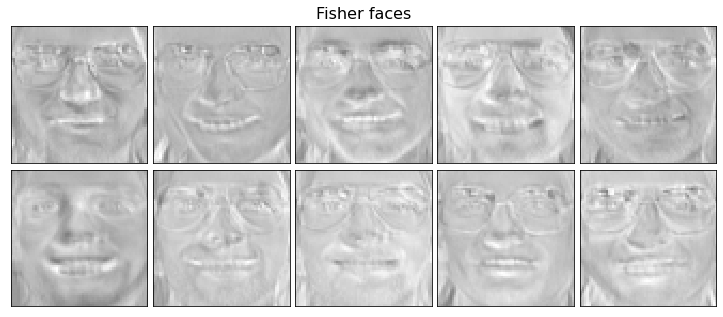

In [ ]:
#To print fisher faces
plot_gallery("Fisher faces", fisher_faces,5,2)

In [ ]:
#reconstructing the faces using fisher faces
U_transpose = W_opt.transpose()    #shape = n_component,n_features

weights_training_data = U_transpose.dot(X_train_use)              #shape = n_component,n_usedimg
weights_test_data = U_transpose.dot(X_test_use)

Ratio_use = int(Ratio*10)*3
nor_weights_training_data = weights_training_data/weights_training_data.sum(axis=0).reshape((1,Ratio_use))
nor_weights_test_data = weights_test_data/weights_test_data.sum(axis=0).reshape((1,n_usedimg-Ratio_use))

reconstruct_faces_training_data = W_opt.dot(nor_weights_training_data)  #shape=n_features,n_usedimg
reconstruct_faces_test_data = W_opt.dot(nor_weights_test_data)

avg_face_training_data = X_train_transpose.mean(axis=1).reshape((n_features,1))
avg_face_test_data = X_test_use.mean(axis=1).reshape((n_features,1))

full_reconstruct_faces_training_data = reconstruct_faces_training_data + avg_face_training_data
full_reconstruct_faces_test_data = reconstruct_faces_test_data + avg_face_test_data

final_full_reconstruct_faces_training_data=full_reconstruct_faces_training_data*255
final_full_reconstruct_faces_test_data=full_reconstruct_faces_test_data*255
final_full_reconstruct_faces_test_data=final_full_reconstruct_faces_test_data+X_test_transpose.mean(axis=1).reshape((4096,1))

faces_from_fisher_faces_training_data=final_full_reconstruct_faces_training_data.T
faces_from_fisher_faces_test_data=final_full_reconstruct_faces_test_data.T

print(weights_training_data.shape)
print(weights_test_data.shape)

(10, 18)
(10, 12)


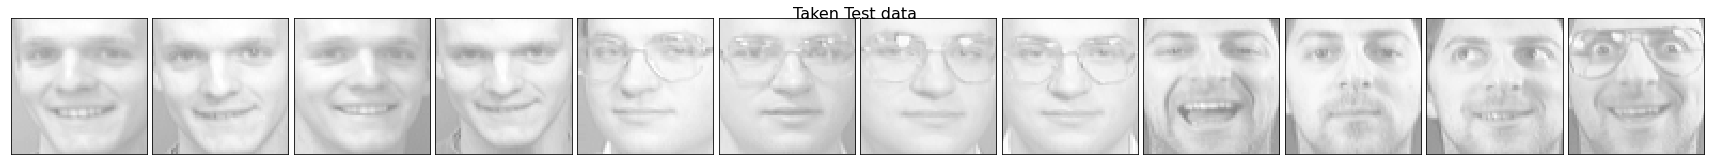

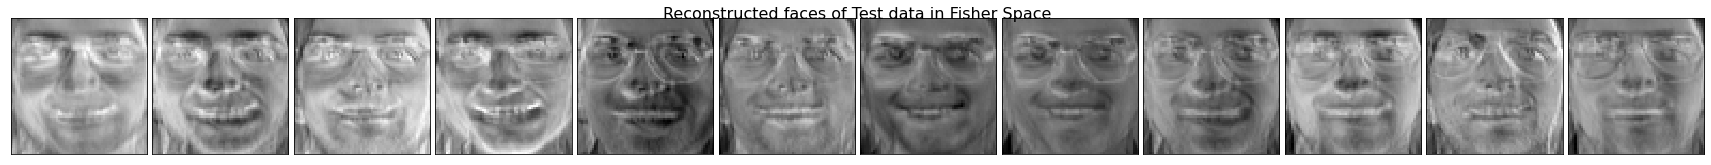

In [ ]:
#To Print Reconstucted faces.
plot_gallery("Taken Test data ", X_test,(30-Ratio_use),1)
plot_gallery("Reconstructed faces of Test data in Fisher Space", faces_from_fisher_faces_test_data,(30-Ratio_use),1)

In [ ]:
#To calculate the euclidean distance and to know min distance between test and training image
i=0
euclidean_dist=np.zeros((n_usedimg-Ratio_use,Ratio_use))
for i in range(n_usedimg-Ratio_use):
  wts_test = (weights_test_data.T)[i].reshape((10,1))
  for j in range(Ratio_use):
    wts_train = (weights_training_data.T)[j].reshape((10,1))
    euclidean_dist[i][j] = la.norm(wts_test-wts_train)
indices = np.argmin(euclidean_dist, axis = 1)  #In tells in each row at which index we got min value of euclidean distance
# print(euclidean_dist[0])
print(indices)

[ 4  3  5  0 10  8  9  6 12 12 13 12]


In [ ]:
#Computing Accuracy of Classifier
label_after_recon=np.zeros((1,n_usedimg-Ratio_use))
loss = np.zeros((1,n_usedimg-Ratio_use))
for i in range(n_usedimg-Ratio_use):
  # print(y_train[indices[i]])
  label_after_recon[0][i] = int(y_train[indices[i]])
  if (label_after_recon[0][i] == y_test.T[0][i]):
    loss[0][i] = 0
  else:
    loss[0][i] = 1
# print(label_after_recon)
#print(y_test.T)
error = (np.sum(loss)/(n_usedimg-Ratio_use))*100
Accuracy = 100 - error
print("Accuracy of classifier is ",Accuracy,"%")


Accuracy of classifier is  100.0 %


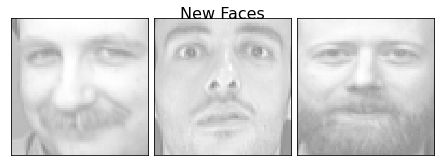

In [ ]:
#Testing classifier on unknown faces
new_face1 = faces[50].reshape(1,n_features)
new_face2 = faces[48].reshape(1,n_features)
new_face3 = faces[100].reshape(1,n_features)
new_face = np.zeros((3,n_features))
new_face[0,:] = new_face1
new_face[1,:]=new_face2
new_face[2,:]=new_face3
plot_gallery("New Faces", new_face[:n_components],3,1)

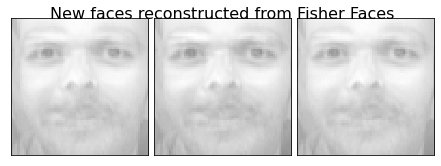

In [ ]:
#Projecting unknown faces on eigen vectors computed from training data
new_faces = (new_face.T)+(new_face.T).mean(axis=1).reshape((4096,1))
weights_new_data = W_opt.T.dot(new_faces)              #shape = n_component,n_usedimg
nor_weights_new_data = weights_new_data/weights_new_data.sum(axis=0).reshape((1,3))
avg_face_new_data = new_faces.mean(axis=1).reshape((n_features,1))
reconstruct_faces_new_data = W_opt.dot(nor_weights_new_data)  #shape=n_features,n_usedimg
full_reconstruct_faces_new_data = reconstruct_faces_new_data + avg_face_new_data
final_full_reconstruct_faces_new_data=full_reconstruct_faces_new_data*255
final_full_reconstruct_faces_new_data=final_full_reconstruct_faces_new_data+(new_face.T).mean(axis=1).reshape((4096,1))
faces_from_fisher_faces_new_data=final_full_reconstruct_faces_new_data.T
plot_gallery("New faces reconstructed from Fisher Faces", faces_from_fisher_faces_new_data,3,1)

In [ ]:
#To calculate the euclidean distance and to know min distance between test and training image
i=0
euclidean_dist_new_data=np.zeros((3,Ratio_use))
for i in range(3):
  wts_new = (weights_new_data.T)[i].reshape((10,1))
  for j in range(Ratio_use):
    wts_train = (weights_training_data.T)[j].reshape((10,1))
    euclidean_dist_new_data[i][j] = la.norm(wts_new-wts_train)
indices_new_data = np.argmin(euclidean_dist_new_data, axis = 1)  #In tells in each row at which index we got min value of euclidean distance
Threshold = 20
label_after_reconstruction=np.zeros((1,3))
for i in range(3):
  value = euclidean_dist_new_data[i][indices_new_data[i]]
  if(value < Threshold):
    label_after_reconstruction[0][i] = int(y_train[indices_new_data[i]])
  else:
    label_after_reconstruction[0][i] = 0    # we are assigning class '0' to unknown images or images having threshold >15
print("Classes assigned to new faces" ,label_after_reconstruction)

Classes assigned to new faces [[0. 0. 0.]]
